# Renewable Energy Forecasting — API Notebook

This notebook demonstrates the **internal API** of this project (not an external web API).

The API is the reusable function layer in:
- `RenewableEnergy_utils.py`

We show how to:
1. Load the raw solar dataset
2. Build time-series features (calendar, lags, rolling means)
3. Create a time-aware train/validation split
4. Train a baseline Random Forest model and evaluate it


In [7]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Notebook is in api/, so project root is one level up
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
RAW_PATH = DATA_DIR / "raw" / "solar_energy.csv"

# Allow importing from project root
sys.path.append(str(PROJECT_ROOT))

from RenewableEnergy_utils import (
    load_data,
    make_basic_time_features,
    train_val_split,
    TARGET_COL,
)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_PATH:", RAW_PATH)


PROJECT_ROOT: /work/class_project/MSML610/Fall2025/Projects/UmdTask15_Fall2025_Renewable_Energy_Production
RAW_PATH: /work/class_project/MSML610/Fall2025/Projects/UmdTask15_Fall2025_Renewable_Energy_Production/data/raw/solar_energy.csv


In [2]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Figure out where we are and where the project root is
NOTEBOOK_DIR = Path.cwd().resolve()


if (NOTEBOOK_DIR / "RenewableEnergy_utils.py").exists():
    PROJECT_ROOT = NOTEBOOK_DIR
else:
    PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"
RAW_PATH = DATA_DIR / "raw" / "solar_energy.csv"

# Make sure Python can see RenewableEnergy_utils.py
sys.path.append(str(PROJECT_ROOT))

from RenewableEnergy_utils import (
    load_data,
    make_basic_time_features,
    train_val_split,
    TIME_COL,
    TARGET_COL,
)

PROJECT_ROOT, RAW_PATH


(PosixPath('/work/class_project/MSML610/Fall2025/Projects/UmdTask15_Fall2025_Renewable_Energy_Production'),
 PosixPath('/work/class_project/MSML610/Fall2025/Projects/UmdTask15_Fall2025_Renewable_Energy_Production/data/raw/solar_energy.csv'))

In [8]:
df_raw = load_data(str(RAW_PATH))
print("Raw shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())
df_raw.head()


Raw shape: (4320, 5)
Columns: ['energy_mwh', 'temp_c', 'cloud_cover', 'solar_radiation', 'wind_speed']


,energy_mwh,temp_c,cloud_cover,solar_radiation,wind_speed
timestamp,,,,,
2024-01-01 00:00:00,0.319,-2.66,0.338,0.0,3.32
2024-01-01 01:00:00,0.491,-2.26,0.410,0.0,3.89
2024-01-01 02:00:00,0.593,1.40,0.526,0.0,4.42
2024-01-01 03:00:00,0.048,-1.41,0.414,0.0,3.94
2024-01-01 04:00:00,0.000,1.97,0.564,0.0,2.96


In [9]:
df_feats = make_basic_time_features(df_raw)
print("Feature shape:", df_feats.shape)
print("Feature columns:", df_feats.columns.tolist())
df_feats.head()


Feature shape: (4296, 13)
Feature columns: ['energy_mwh', 'temp_c', 'cloud_cover', 'solar_radiation', 'wind_speed', 'hour', 'dayofweek', 'month', 'energy_mwh_lag_1', 'energy_mwh_lag_2', 'energy_mwh_lag_24', 'energy_mwh_rollmean_3', 'energy_mwh_rollmean_24']


,energy_mwh,temp_c,cloud_cover,solar_radiation,wind_speed,hour,dayofweek,month,energy_mwh_lag_1,energy_mwh_lag_2,energy_mwh_lag_24,energy_mwh_rollmean_3,energy_mwh_rollmean_24
timestamp,,,,,,,,,,,,,
2024-01-02 00:00:00,0.000,-2.72,0.516,0.0,3.61,0,1,1,0.230,0.413,0.319,0.214333,5.352333
2024-01-02 01:00:00,0.438,-1.63,0.469,0.0,2.62,1,1,1,0.000,0.230,0.491,0.214333,5.339042
2024-01-02 02:00:00,0.377,-0.89,0.143,0.0,2.39,2,1,1,0.438,0.000,0.593,0.222667,5.336833
2024-01-02 03:00:00,0.721,-0.35,0.559,0.0,3.10,3,1,1,0.377,0.438,0.048,0.271667,5.327833
2024-01-02 04:00:00,0.426,0.68,0.365,0.0,3.62,4,1,1,0.721,0.377,0.000,0.512000,5.355875


In [10]:
X_train, X_val, y_train, y_val, feature_cols = train_val_split(df_feats, test_size_days=7)

print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("y_train:", y_train.shape)
print("y_val  :", y_val.shape)
print("Num features:", len(feature_cols))
print("Feature cols:", feature_cols)


X_train: (4128, 12)
X_val  : (168, 12)
y_train: (4128,)
y_val  : (168,)
Num features: 12
Feature cols: ['temp_c', 'cloud_cover', 'solar_radiation', 'wind_speed', 'hour', 'dayofweek', 'month', 'energy_mwh_lag_1', 'energy_mwh_lag_2', 'energy_mwh_lag_24', 'energy_mwh_rollmean_3', 'energy_mwh_rollmean_24']


In [11]:


rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print(f"Validation MAE : {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")


Validation MAE : 0.3972
Validation RMSE: 0.5188


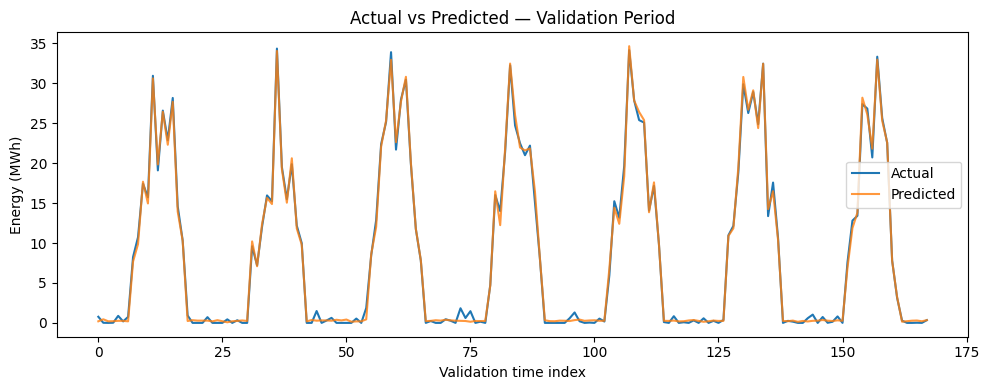

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(y_val.values, label="Actual")
plt.plot(y_pred, label="Predicted", alpha=0.8)
plt.xlabel("Validation time index")
plt.ylabel("Energy (MWh)")
plt.title("Actual vs Predicted — Validation Period")
plt.legend()
plt.tight_layout()
plt.show()



## Summary

In this notebook, we used the project’s internal API (functions in `RenewableEnergy_utils.py`) to:

- Load the raw hourly solar dataset (`load_data`)
- Build time-series forecasting features (`make_basic_time_features`)
- Create a time-aware train/validation split (`train_val_split`)
- Train and evaluate a baseline RandomForest model

This demonstrates a clean “API layer” that can be reused in scripts, notebooks, and apps without duplicating feature engineering logic.
